# Prediciting Match Outcomes to beat the bookies

## Introduction

When someone is prepared to risk money, small or large, on their favourite sports team or simply as a bit of casual fun or may it be they are trying to make money. There is only one main aim and that is to beat the bookies and generate a higher return than initally staked.  

The casual gambler might be putting on bets for their favorite sports team and may play based off emotions rather than informed decisions which more than likely leads to a number of losses.  

However the professional sports bettor will use a combination of information and experience to understand whether the odds offered by the bookies are in favour of the house or not. They do not bet based off emotions but off years of experience and research. 

This project aims to replicate the knowledge that a professional punter would use to determine whether a bet is worth risking money on, whilst every individual has their own risk appetite we hope the models built in this project will be able to predict outcomes based on statistical properties of past matches. 

This could then aid bettors in making their decisions on what outcome to bet on and potentially beat the bookies. 

Using a dataset provided by https://www.football-data.co.uk/ that contains match data as well as FIFA player statistics, I will build a model to predict the probability of each match outcome where the outcome is one of - Win, Draw or Loss. 

In [66]:
# Import packages

import numpy as np
import sqlite3
import pandas as pd
import seaborn as sns
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import os
import warnings
warnings.simplefilter(action="ignore")


In [2]:
# Import Data

database = 'data/database.sqlite'
conn = sqlite3.connect(database)

# Choosing tables from sqldatabase 

player_df = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_df = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_df = pd.read_sql("SELECT * FROM Team;", conn)
match_df = pd.read_sql("SELECT * FROM Match;", conn)

# Removing Na values from match data
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]

match_df.dropna(subset=rows, inplace=True)

In [3]:
# Displaying attributes of the data 
# Show what countries are included in the dataset and the names of the leagues in mentioned country (as there are multiple leagues)

pd.read_sql("SELECT * FROM League JOIN Country ON Country.id = League.country_id;", conn)

# 

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


In [ ]:
pd.read_sql("SELECT * FROM Match;", conn)

In [19]:
years = np.arange(5,23) 
years_1 = np.arange(6,24)

## Convert to string and add trailing 0 
## required for website url data is stored on 

years = years.astype(str)
years = np.char.zfill(years, 2)

years_1 = years_1.astype(str)
years_1 = np.char.zfill(years_1, 2)

## Combining to give out the final years
url_years = np.core.defchararray.add(years, years_1)

data_url_base = 'https://www.football-data.co.uk/mmz4281/{Year}/E0.csv'


## Check if the data already exists locally (previously compiled incase of no internet)

if os.path.exists("data/football_data.csv"):
    df = pd.read_csv("data/football_data.csv", low_memory=False, index_col=False)
else:
    ## creating url list with all years needed
    ## Also adding delimiter '/' between seasons for new column 
    data_urls_list = []
    season = []
    for year in url_years:
        url_with_year = data_url_base.replace('{Year}', year)
        season_year = year[:2] + '/' + year[2:]
        season.append(season_year)
        data_urls_list.append(url_with_year)

    df_list =[] 

    for file in enumerate(data_urls_list):
        df = pd.read_csv(file[1])
        df['Season'] = season[file[0]]
        df_list.append(df)
    
    df = pd.concat(df_list, ignore_index=True)

cols_to_keep = ['Date','Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR','Season']

df = df[cols_to_keep]



## Removing latest season as season not finished 
df = df[df.Season != "22/23"]

# Convert Date and Time columns 

df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], format="%H:%M").dt.time

# Replacing some names as seem to be incomplete from older seasons
df.replace('D Gallaghe', 'D Gallagher', inplace=True)
df.replace('D Gallagh', 'D Gallagher', inplace=True)
df.replace('Mn Atkinson', 'M Atkinson', inplace=True)
df.replace('l Mason', 'L Mason', inplace=True)

df.dropna(inplace=True)
df.isna().sum()

Date        0
Time        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
Referee     0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
Season      0
dtype: int64

In [20]:
# Create Home Win, Draw Win and Away Win columns
df = df.assign(homeWin=lambda df: df.apply(lambda row: 1 if row.FTHG > row.FTAG else 0, axis='columns'),
              draw=lambda df: df.apply(lambda row: 1 if row.FTHG == row.FTAG else 0, axis='columns'),
              awayWin=lambda df: df.apply(lambda row: 1 if row.FTHG < row.FTAG else 0, axis='columns'))

## Data

In [6]:
display(df)

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,...,HF,AF,HC,AC,HY,AY,HR,AR,Season,Result
5321,2019-09-08,20:00:00,Liverpool,Norwich,4.0,1.0,H,M Oliver,15.0,12.0,...,9.0,9.0,11.0,2.0,0.0,2.0,0.0,0.0,19/20,1
5322,2019-10-08,12:30:00,West Ham,Man City,0.0,5.0,A,M Dean,5.0,14.0,...,6.0,13.0,1.0,1.0,2.0,2.0,0.0,0.0,19/20,-1
5323,2019-10-08,15:00:00,Bournemouth,Sheffield United,1.0,1.0,D,K Friend,13.0,8.0,...,10.0,19.0,3.0,4.0,2.0,1.0,0.0,0.0,19/20,0
5324,2019-10-08,15:00:00,Burnley,Southampton,3.0,0.0,H,G Scott,10.0,11.0,...,6.0,12.0,2.0,7.0,0.0,0.0,0.0,0.0,19/20,1
5325,2019-10-08,15:00:00,Crystal Palace,Everton,0.0,0.0,D,J Moss,6.0,10.0,...,16.0,14.0,6.0,2.0,2.0,1.0,0.0,1.0,19/20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,2022-05-22,16:00:00,Crystal Palace,Man United,1.0,0.0,H,M Atkinson,6.0,10.0,...,12.0,22.0,3.0,6.0,2.0,4.0,0.0,0.0,21/22,1
6457,2022-05-22,16:00:00,Leicester,Southampton,4.0,1.0,H,J Moss,12.0,7.0,...,10.0,5.0,3.0,3.0,0.0,1.0,0.0,0.0,21/22,1
6458,2022-05-22,16:00:00,Liverpool,Wolves,3.0,1.0,H,A Taylor,29.0,7.0,...,6.0,3.0,5.0,3.0,1.0,0.0,0.0,0.0,21/22,1
6459,2022-05-22,16:00:00,Man City,Aston Villa,3.0,2.0,H,M Oliver,24.0,4.0,...,5.0,11.0,13.0,1.0,0.0,1.0,0.0,0.0,21/22,1


## Summary Statistics

In [7]:
df.describe()

,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Result
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,1.460526,1.284211,13.328947,11.500000,4.592982,4.073684,10.587719,10.563158,5.644737,4.794737,1.554386,1.652632,0.052632,0.064912,0.071053
std,1.300106,1.239501,5.535554,5.163609,2.570369,2.448380,3.519197,3.649775,3.095370,2.747170,1.207101,1.211027,0.231121,0.256943,0.874597
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,9.000000,8.000000,3.000000,2.000000,8.000000,8.000000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,-1.000000
50%,1.000000,1.000000,13.000000,11.000000,4.000000,4.000000,11.000000,10.000000,5.000000,4.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,17.000000,15.000000,6.000000,5.250000,13.000000,13.000000,7.000000,6.000000,2.000000,2.000000,0.000000,0.000000,1.000000
max,9.000000,9.000000,31.000000,31.000000,15.000000,15.000000,23.000000,25.000000,17.000000,16.000000,6.000000,6.000000,2.000000,2.000000,1.000000


### Contingency tables



In [8]:
#Display some contingency tables to show high level frequency distribution of some key variables that may affect result
dfHTeamResultCont = pd.crosstab(df['HomeTeam'], 
                             df['FTR'], margins=False)
            
dfATeamResultCont = pd.crosstab(df['AwayTeam'], 
                             df['FTR'], margins=False)

dfRefResult = pd.crosstab(df['Referee'],
                             df['FTR'])


print("Home team vs Full Time Result")           
display(dfHTeamResultCont)

print("Away team vs Full Time Result")
display(dfATeamResultCont)

print("Referee vs Full Time Result")
display(dfRefResult)

Home team vs Full Time Result


FTR,A,D,H
HomeTeam,,,
Arsenal,14,12,31
Aston Villa,25,12,20
Bournemouth,8,6,5
Brentford,9,3,7
Brighton,20,23,14
Burnley,24,16,17
Chelsea,12,16,29
Crystal Palace,20,18,19
Everton,21,13,23


Away team vs Full Time Result


FTR,A,D,H
AwayTeam,,,
Arsenal,23,12,22
Aston Villa,18,9,30
Bournemouth,4,1,14
Brentford,6,4,9
Brighton,16,20,21
Burnley,15,16,26
Chelsea,31,11,15
Crystal Palace,15,15,27
Everton,18,11,28


Referee vs Full Time Result


FTR,A,D,H
Referee,,,
A Madley,13,11,19
A Marriner,27,19,22
A Moss,1,0,0
A Taylor,28,21,39
C Kavanagh,22,14,30
C Pawson,25,16,31
D Coote,21,12,24
D England,10,7,10
G Scott,17,6,20


In [22]:
# As seen in the above table there are referees who are either new or havent officiated many games. 
# For this project I will be removing those referees who haven't officiated more than 30 games. 

df = df[df.groupby('Referee')['Referee'].transform('size') >30]

Do referees influence the game? A lot of sports bettors are aware of what is known as the home advantage and is this something that they should be wary of when placing bets?
If referees are biased towards the home team you may want to take this into account when making your selection. 

In [24]:
print('Home Win Rate: {:.4}%'.format(df.homeWin.mean() * 100))

print("Home Win Rate by Ref")
df.groupby('Referee').homeWin.mean().sort_values(ascending=False)

Home Win Rate: 42.36%
Home Win Rate by Ref


Referee
J Moss        0.486486
G Scott       0.465116
M Atkinson    0.464286
C Kavanagh    0.454545
A Taylor      0.443182
A Madley      0.441860
P Bankes      0.435897
C Pawson      0.430556
K Friend      0.426471
S Hooper      0.421053
D Coote       0.421053
M Dean        0.410256
S Attwell     0.406250
M Oliver      0.395349
P Tierney     0.369863
A Marriner    0.323529
Name: homeWin, dtype: float64

Jonathan Moss has the highest win rate for home sides. Does this mean he shows bias towards them?   
That is not neccesarily the case, it could just be that he is regularly in charge of teams towards the top end of the league table who tend to have a higher win rate as their team performs much better regularly.  

However this isn't to say that there is no relationship between referees and the Full Time Result

In [27]:
# Performing Chi Squared tests on these two variables to see if any significance can be drawn from the statement made 
from scipy.stats import chi2_contingency



# Create a contingency table
contingencyTableRef = pd.crosstab(df['Referee'], df['FTR'])

# Calculate chi-squared statistic and p-value
chi2, p, dof, expected = chi2_contingency(contingencyTableRef)

if p < 0.05:
    print("There is a significant association between Referee in charge and the Full Time Result")
else:
    print("There is no significant association between the Referee in charge and the Full Time Result")

There is no significant association between the Referee in charge and the Full Time Result


### Correlation matrix and plot

In [28]:
## Keeping only continuous columns 

df_continuous = df.select_dtypes(include=[np.number])

c_matrix = df_continuous.corr()
c_matrix


,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,homeWin,draw,awayWin
FTHG,1.000000,-0.184300,0.362554,-0.232016,0.628939,-0.186796,-0.071237,-0.049878,0.072897,-0.125317,-0.163143,-0.015882,-0.082862,0.102707,0.663004,-0.202122,-0.509546
FTAG,-0.184300,1.000000,-0.228619,0.414921,-0.228001,0.640710,-0.046533,0.002178,-0.148911,0.079811,0.058444,-0.054551,0.131833,-0.119564,-0.532392,-0.133685,0.669052
HS,0.362554,-0.228619,1.000000,-0.447190,0.677011,-0.320273,-0.040009,-0.062436,0.536140,-0.322532,-0.097544,0.068058,-0.095778,0.091594,0.266390,-0.017450,-0.260716
AS,-0.232016,0.414921,-0.447190,1.000000,-0.323177,0.714275,-0.025531,0.002558,-0.343443,0.532490,0.102514,-0.074939,0.176280,-0.146398,-0.296123,0.008331,0.299533
HST,0.628939,-0.228001,0.677011,-0.323177,1.000000,-0.259835,-0.021608,-0.043578,0.307736,-0.202910,-0.135672,0.036548,-0.074561,0.111779,0.469509,-0.101191,-0.397664
AST,-0.186796,0.640710,-0.320273,0.714275,-0.259835,1.000000,-0.003828,0.019150,-0.250979,0.302708,0.070846,-0.062423,0.156676,-0.147194,-0.372773,-0.078782,0.455446
HF,-0.071237,-0.046533,-0.040009,-0.025531,-0.021608,-0.003828,1.000000,0.146960,0.013335,-0.044836,0.355035,0.094496,0.026001,0.019907,-0.019353,0.048428,-0.022468
AF,-0.049878,0.002178,-0.062436,0.002558,-0.043578,0.019150,0.146960,1.000000,-0.065241,-0.004839,0.083838,0.329814,0.031696,0.051633,-0.014662,0.020306,-0.002636
HC,0.072897,-0.148911,0.536140,-0.343443,0.307736,-0.250979,0.013335,-0.065241,1.000000,-0.264120,-0.014135,0.052026,-0.098332,0.065223,0.081651,0.030211,-0.111134
AC,-0.125317,0.079811,-0.322532,0.532490,-0.202910,0.302708,-0.044836,-0.004839,-0.264120,1.000000,0.032933,-0.023287,0.060620,-0.095270,-0.064976,-0.000670,0.067917


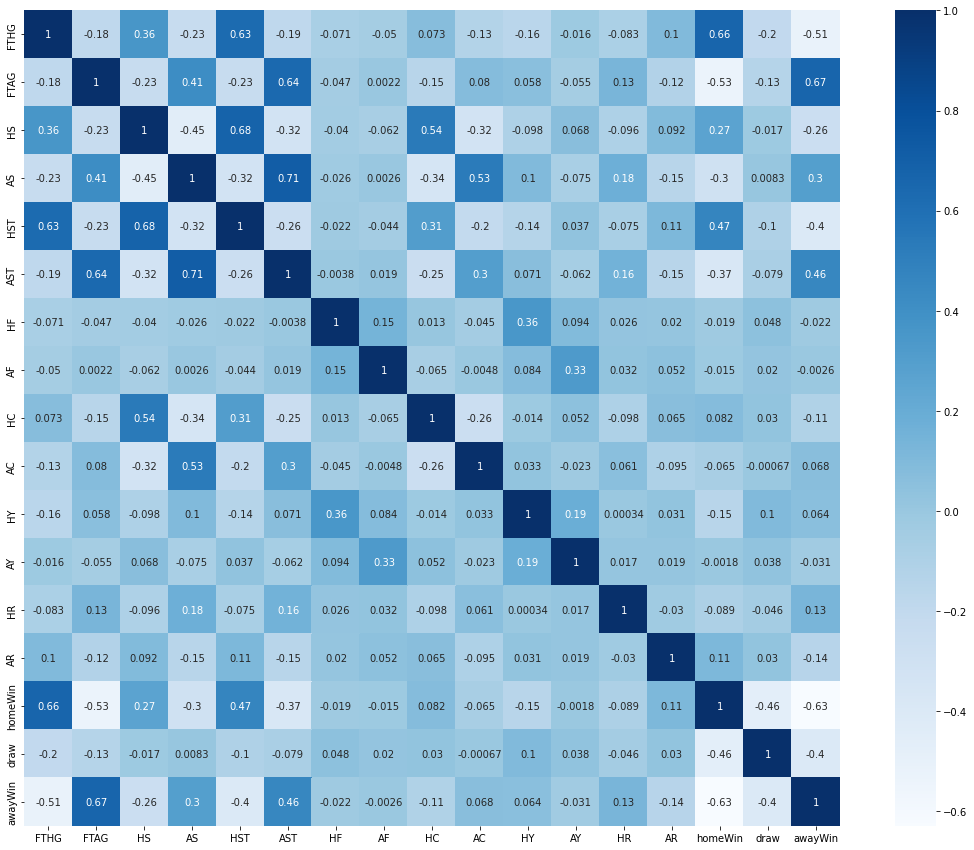

In [29]:
# Visualising the correlation matrix using a heatmap

fig, ax = plt.subplots(figsize = (20,15))
sns.heatmap(c_matrix, square = True, cmap = 'Blues', annot=True);

A lot of the variables that seem to be strong correlated with each other are unsurprising here as these are things we typically expect during a game. 
Examples include Home Shots and Home Shots on Target or Home Fouls and Home Yellow Cards. These types of things co-occur or are the direct result of the other so this is expected to be the case. 


## Variable correlation with win margin

To further investigate the relationship between variables we can look at the relationship each game statistic has with the winning margin to see if this heatmap changes and produces further insights. 

In [35]:
df['win_margin'] = df['FTHG'] - df['FTAG']

game_stat_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY','HR', 'AR', 'win_margin']

game_stat_corr = df[game_stat_cols].corr()
game_stat_corr['win_margin'].sort_values()

AST          -0.528945
AS           -0.416775
HY           -0.145916
HR           -0.138534
AC           -0.134106
AF           -0.034716
HF           -0.018273
AY            0.023787
HC            0.142644
AR            0.144062
HS            0.386541
HST           0.564223
win_margin    1.000000
Name: win_margin, dtype: float64

Focusing on the correlation between our feature columns or game statistics against the win margin there are things we can see that are not totally surprisng which most sports fan would expect to see. 
For example all variables that are positively correlated to the win margin (difference between Home Goals Scored and Away Goals Scored) are things such as Home Shots, Home Corners, Away Reds. 

There are however some variables we aren't expecting to see such as Home Yellows/Reds negatively correlating with winning margin however this could be due to several factors, one explanation being that the home side maybe tend to play much more aggresively if they are trailing in the game which could lead to more yellow/red cards.

<AxesSubplot:>

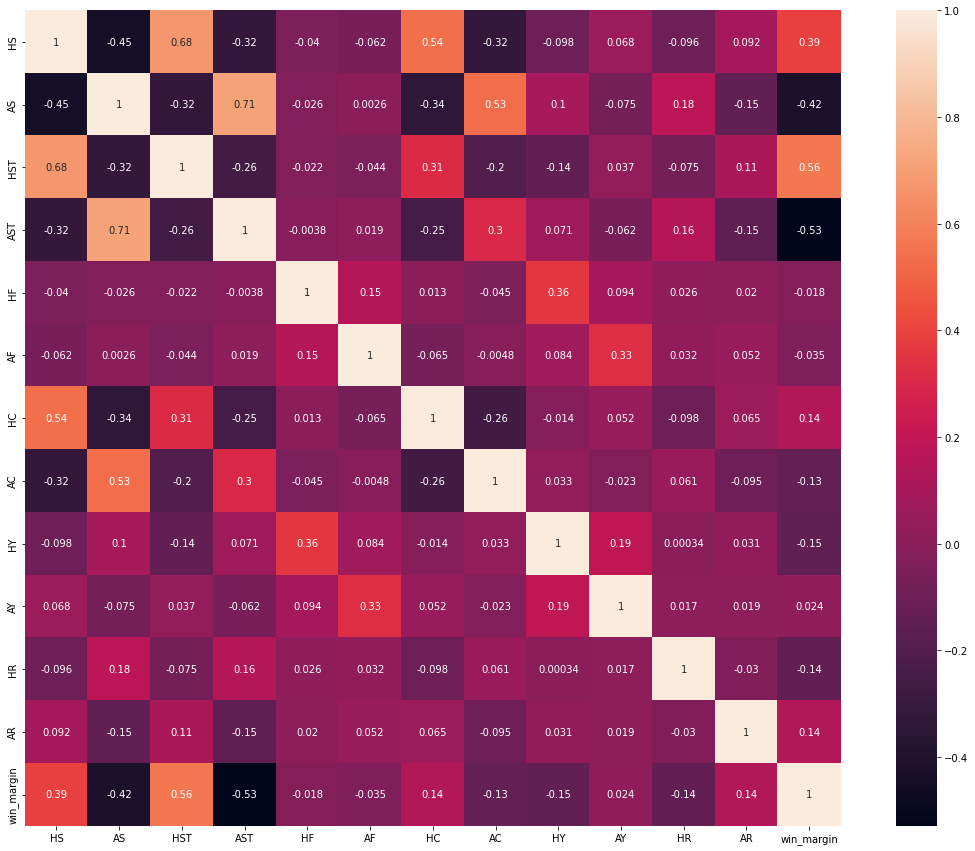

In [39]:
#Heatmap using game stat cols
fig, ax = plt.subplots(figsize = (20,15))
sns.heatmap(game_stat_corr, square = True, annot=True )

Again from this

In [31]:
df.columns

Index(['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
       'HR', 'AR', 'Season', 'homeWin', 'draw', 'awayWin', 'win_margin'],
      dtype='object')

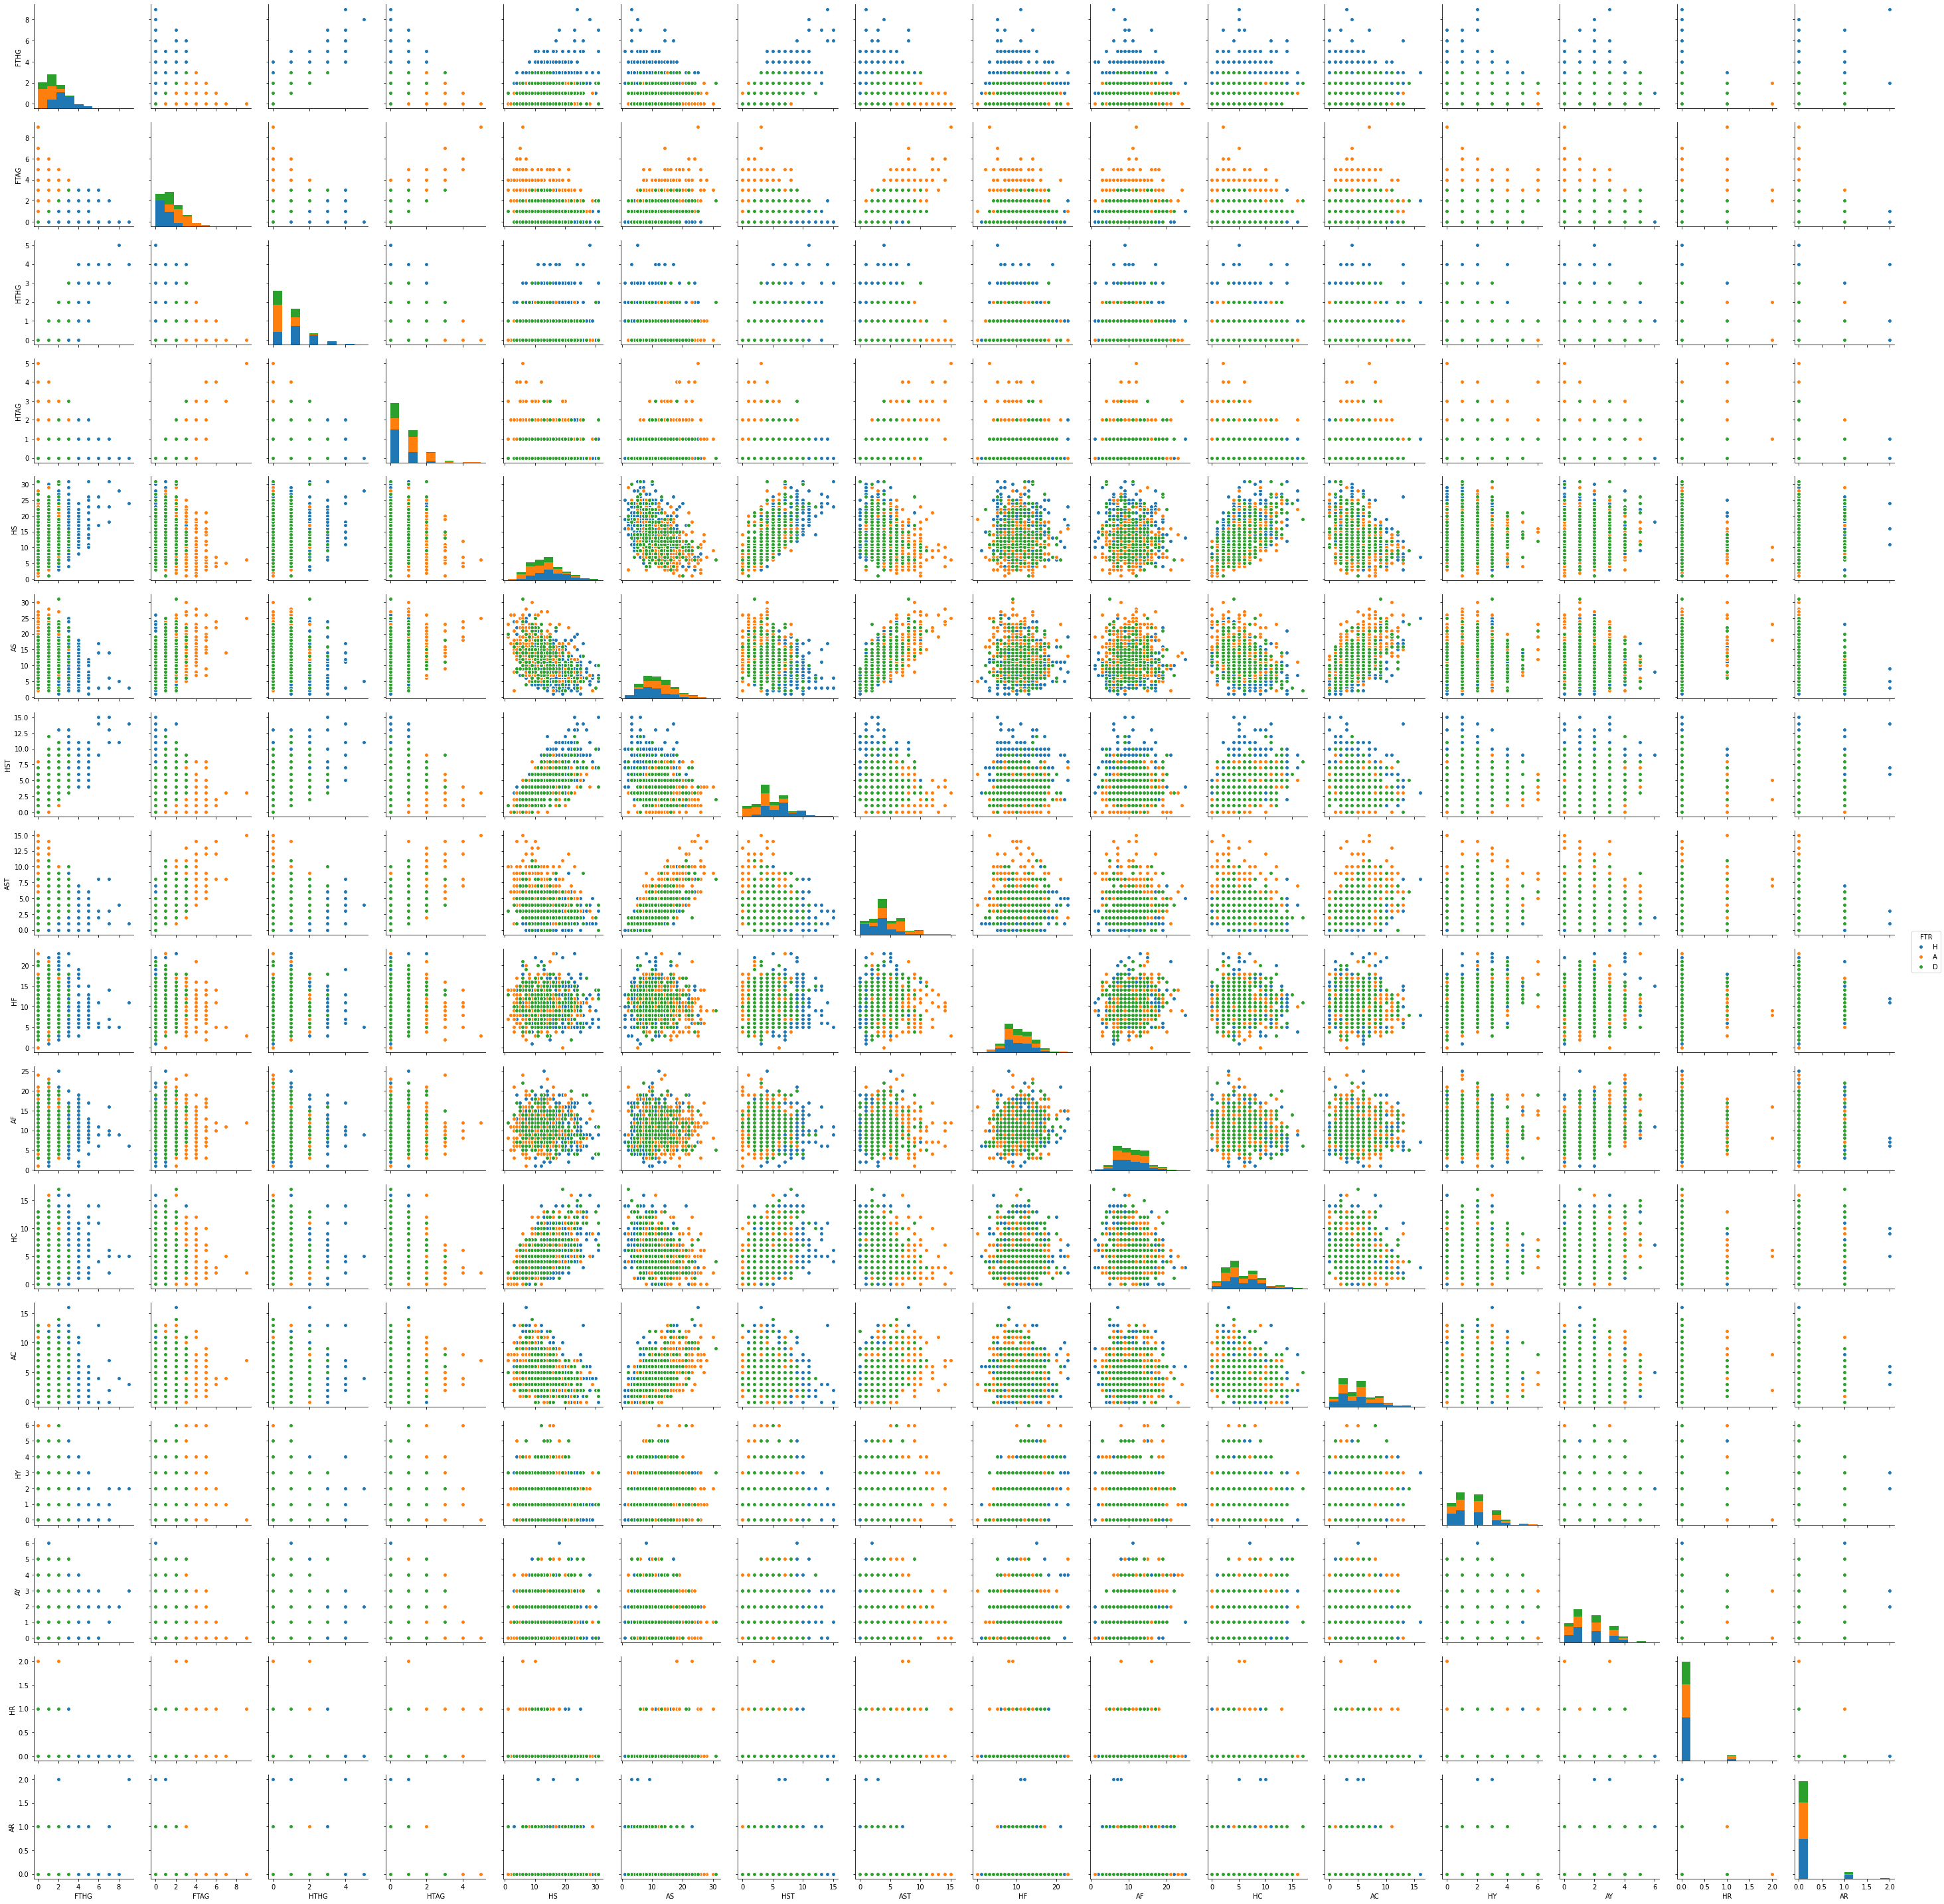

In [10]:
sns.pairplot(df, hue='FTR')

In [45]:
df.select_dtypes('number').columns

Index(['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY',
       'AY', 'HR', 'AR', 'homeWin', 'draw', 'awayWin', 'win_margin'],
      dtype='object')

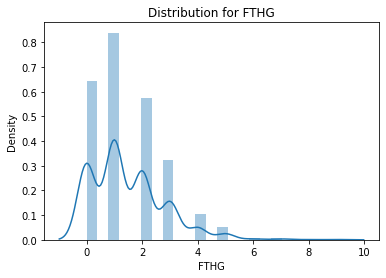

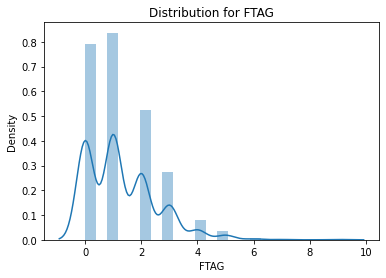

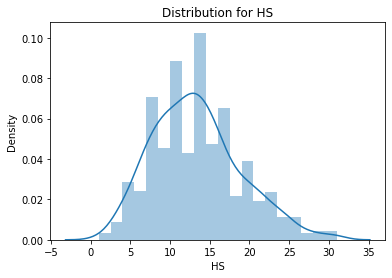

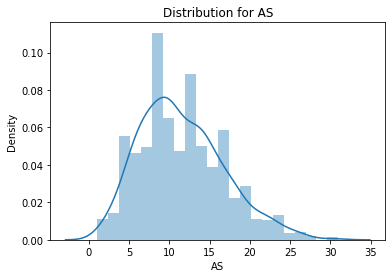

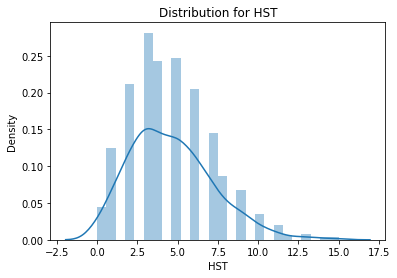

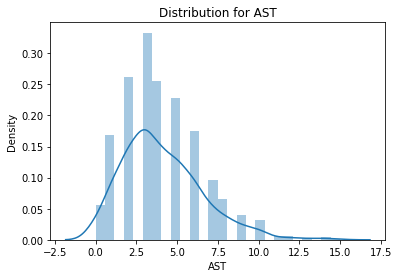

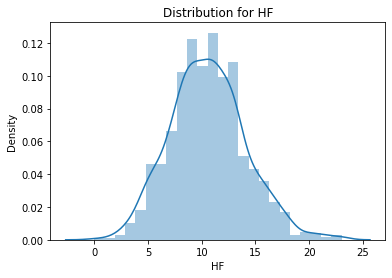

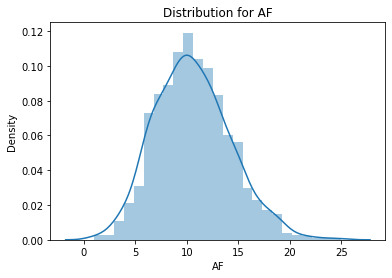

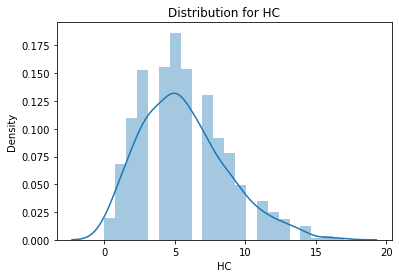

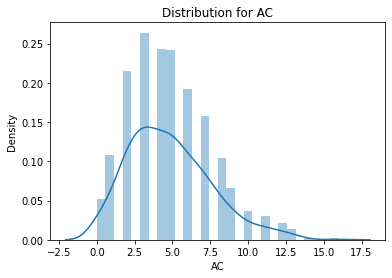

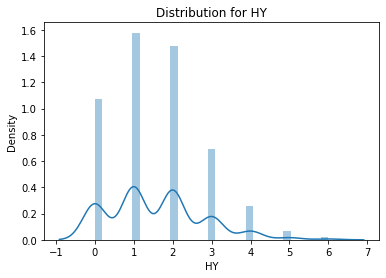

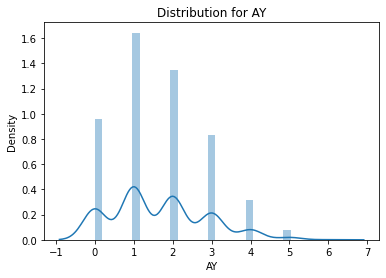

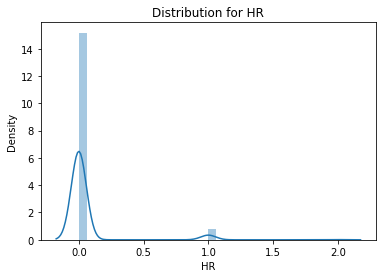

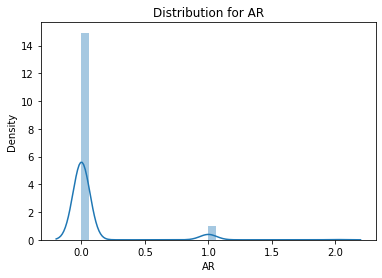

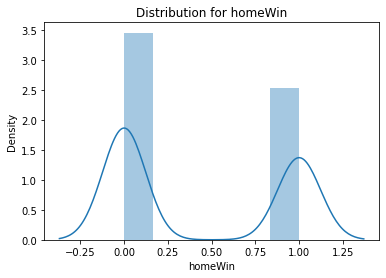

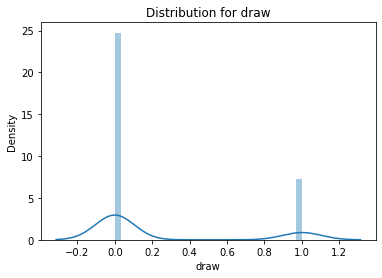

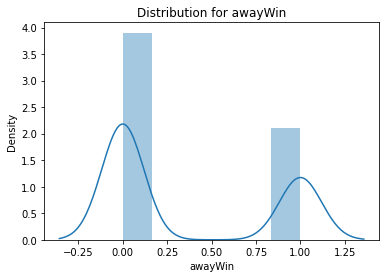

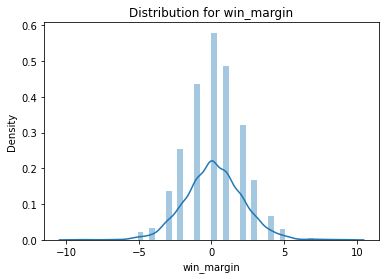

In [49]:
for col in df.select_dtypes('number').columns:
    sns.distplot(df[col])
    plt.title(f"Distribution for {col}")
    plt.show()

# Train ML models

In [87]:
features

,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
5321,4.0,1.0,H,15.0,12.0,7.0,5.0,9.0,9.0,11.0,2.0,0.0,2.0,0.0,0.0
5322,0.0,5.0,A,5.0,14.0,3.0,9.0,6.0,13.0,1.0,1.0,2.0,2.0,0.0,0.0
5323,1.0,1.0,D,13.0,8.0,3.0,3.0,10.0,19.0,3.0,4.0,2.0,1.0,0.0,0.0
5324,3.0,0.0,H,10.0,11.0,4.0,3.0,6.0,12.0,2.0,7.0,0.0,0.0,0.0,0.0
5325,0.0,0.0,D,6.0,10.0,2.0,3.0,16.0,14.0,6.0,2.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,1.0,0.0,H,6.0,10.0,3.0,4.0,12.0,22.0,3.0,6.0,2.0,4.0,0.0,0.0
6457,4.0,1.0,H,12.0,7.0,6.0,2.0,10.0,5.0,3.0,3.0,0.0,1.0,0.0,0.0
6458,3.0,1.0,H,29.0,7.0,8.0,5.0,6.0,3.0,5.0,3.0,1.0,0.0,0.0,0.0
6459,3.0,2.0,H,24.0,4.0,5.0,2.0,5.0,11.0,13.0,1.0,0.0,1.0,0.0,0.0


In [89]:
# Replace H,A,D with numerical values for model usages
features = df.drop(['homeWin', 'draw', 'awayWin', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'win_margin', 'Referee', 'FTR'], axis=1)
target_var = df[['FTR']].replace(['H','A','D'], [0,1,2])

In [90]:
# Split the data into test and train datasets. 

X_train, X_test, y_train, y_test = train_test_split(features, target_var, test_size=0.2, random_state=42, stratify=target_var)

In [91]:
# Listing out all ML models to pass the data on . 

names = ["K-Nearest Neighbors", "Logistic Regression","Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest Classifier", "Multi-layer Perceptron Classifier (Neural Network)", "AdaBoost",
         "Naive Bayes", "QuadraticDiscriminantAnalysis"]

classifiers = [
    KNeighborsClassifier(n_neigbours = 3),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [97]:
# Iterate through each classifier and produce accuracy scores. 

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)

        prediction_proba = clf.predict_proba(X_test)
        logloss = log_loss(y_test,prediction_proba)
        precision, recall, fscore, support = score(y_test, y_predict)
        conf_martrix = confusion_matrix(y_test, y_predict)
        clas_report = classification_report(y_test, y_predict)

        print(name, accuracy)
        print(clas_report)

K-Nearest Neighbors 0.6076555023923444
              precision    recall  f1-score   support

           0       0.61      0.79      0.69        89
           1       0.67      0.58      0.62        73
           2       0.48      0.32      0.38        47

    accuracy                           0.61       209
   macro avg       0.59      0.56      0.56       209
weighted avg       0.60      0.61      0.59       209

Logistic Regression 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        73
           2       1.00      1.00      1.00        47

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209

Linear SVM 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        

The above results seem to suggest that there are a few models that give us a 100% prediction rate however this is highly unlikely and there may be something incorrect with the way the data is interacting with the models that is causing this error. 

There could be a number of reasons why this is occuring:  

- Overfitting: The models maybe be overfitting the training data indicating that the data might have a lot of noise in it therefore the models are learning the noise rather than the underlying trends.  
- Data imbalance: The data may have an imbalance with several classes.
- Too many features: if there are features that arent relevant to the prediction or if there are features that are highly correlated the models may be able to predict this purely by chance. 

In [102]:
features.columns

Index(['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY',
       'AY', 'HR', 'AR'],
      dtype='object')

From the reasons I provided earlier it may be the case that too many features were selected causing noise. I pointed out earlier there are some variables that co-occur for example Home Shot and Home Shots on Target which could be interfering with the performance of the model.  

Therefore I will go through another iteration of model tuning with better feature selection this round. 

## Recursive Feature Selection (RFE)

Recusive Feature Elimination or RFE is a popular feature selection algorithm which is easy to use and helps select features from the dataset provided that are relevant for predicting the target variable, while eliminating those that are not as important. RFE works by recursively removing features one at a time, and then building a model using the remaining features. The feature that results in the lowest performance of the model is then removed, and this process is repeated until a desired number of features is reached. This method is useful in cases where there are a large number of features, and it is difficult to identify which ones are important.

https://machinelearningmastery.com/rfe-feature-selection-in-python/ 




In [110]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(features)
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=6, step=10, verbose=5)
rfe_selector.fit(X_norm, target_var)
rfe_support = rfe_selector.get_support()
rfe_feature = features.loc[:,rfe_support].columns.tolist()


print(str(len(rfe_feature)), 'selected features')
# Features chosen by RFE algorithm
rfe_feature

Fitting estimator with 14 features.
6 selected features


['FTHG', 'FTAG', 'HST', 'AST', 'AC', 'AR']

### PCA

In [98]:
features

,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
5321,4.0,1.0,15.0,12.0,7.0,5.0,9.0,9.0,11.0,2.0,0.0,2.0,0.0,0.0
5322,0.0,5.0,5.0,14.0,3.0,9.0,6.0,13.0,1.0,1.0,2.0,2.0,0.0,0.0
5323,1.0,1.0,13.0,8.0,3.0,3.0,10.0,19.0,3.0,4.0,2.0,1.0,0.0,0.0
5324,3.0,0.0,10.0,11.0,4.0,3.0,6.0,12.0,2.0,7.0,0.0,0.0,0.0,0.0
5325,0.0,0.0,6.0,10.0,2.0,3.0,16.0,14.0,6.0,2.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,1.0,0.0,6.0,10.0,3.0,4.0,12.0,22.0,3.0,6.0,2.0,4.0,0.0,0.0
6457,4.0,1.0,12.0,7.0,6.0,2.0,10.0,5.0,3.0,3.0,0.0,1.0,0.0,0.0
6458,3.0,1.0,29.0,7.0,8.0,5.0,6.0,3.0,5.0,3.0,1.0,0.0,0.0,0.0
6459,3.0,2.0,24.0,4.0,5.0,2.0,5.0,11.0,13.0,1.0,0.0,1.0,0.0,0.0


* Insert what PCA is and reference   
https://builtin.com/data-science/step-step-explanation-principal-component-analysis


Principal Component Analysis or PCA is a dimensionality reduction method often used in Machine Learning model to reduce dimentionality of large data sets. It is done by transforming variables in a large data set into a smaller one that contains majority of the information from the larger data set. 

There is a trade off with accuracy but this is performed to make the models much simpler to explore and visualise without including many of the irrelevant variables in the dataset. 

Once we've completed our modelling we may later decide to include more features if we believe they have an impact on our target variable. 

According to this source, https://www.originlab.com/doc/Origin-Help/PrincipleComp-Analysis#:~:text=PCA%20should%20be%20used%20mainly,0.3%2C%20PCA%20will%20not%20help. PCA does not work very well to reduce data if the relationship is weak between variables. In general if most of the correlation coefficients are less than 0.3, PCA will not help. 

As seen in the correlation heatmaps shown earlier majority of the statistics were not strong correlated (except for the stats that co-occur i.e. Away Shot and Away Shots on Target)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

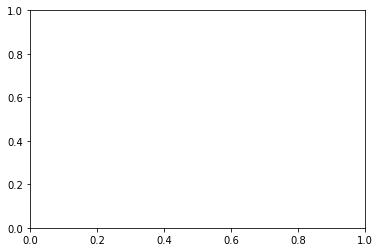

In [43]:
# Plotting out optimal PCA components to determine how many components to use 
pca = PCA(n_components=None)
pca.fit(df[game_stat_cols])

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 17), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 17), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(range(0, len(exp_var), 1))
plt.legend(loc='best')
plt.tight_layout()

In [44]:
game_stat_cols

['HS',
 'AS',
 'HST',
 'AST',
 'HF',
 'AF',
 'HC',
 'AC',
 'HY',
 'AY',
 'HR',
 'AR',
 'win_margin']

The above plot is showing the explained variance percentage of each individual component and its cumulative explained variance percentages after PCA is applied.  
From this we can see only one component really explains a large proportion of the variance in the data. This indicates that maybe PCA is not as neccesary for this dataset as much of the variance is broadly spread across the different variables.  

In [29]:
X = df_continuous.drop(['Result'], axis=1)
y = df['Result'].values
#Splitting the data into Train, and Test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [30]:
X

,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
5321,4.0,1.0,15.0,12.0,7.0,5.0,9.0,9.0,11.0,2.0,0.0,2.0,0.0,0.0
5322,0.0,5.0,5.0,14.0,3.0,9.0,6.0,13.0,1.0,1.0,2.0,2.0,0.0,0.0
5323,1.0,1.0,13.0,8.0,3.0,3.0,10.0,19.0,3.0,4.0,2.0,1.0,0.0,0.0
5324,3.0,0.0,10.0,11.0,4.0,3.0,6.0,12.0,2.0,7.0,0.0,0.0,0.0,0.0
5325,0.0,0.0,6.0,10.0,2.0,3.0,16.0,14.0,6.0,2.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,1.0,0.0,6.0,10.0,3.0,4.0,12.0,22.0,3.0,6.0,2.0,4.0,0.0,0.0
6457,4.0,1.0,12.0,7.0,6.0,2.0,10.0,5.0,3.0,3.0,0.0,1.0,0.0,0.0
6458,3.0,1.0,29.0,7.0,8.0,5.0,6.0,3.0,5.0,3.0,1.0,0.0,0.0,0.0
6459,3.0,2.0,24.0,4.0,5.0,2.0,5.0,11.0,13.0,1.0,0.0,1.0,0.0,0.0


In [68]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score, confusion_matrix, roc_auc_score, classification_report, log_loss

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [31]:
names = ["Nearest Neighbors", "Logistic Regression","Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [32]:
import warnings
warnings.simplefilter(action='ignore')

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)

        # prediction_proba = clf.predict_proba(X_test)
        # logloss = log_loss(y_test,prediction_proba)
        # precision, recall, fscore, support = score(y_test, prediction)
        # conf_martrix = confusion_matrix(y_test, prediction)
        # clas_report = classification_report(y_test, prediction)

        print(name, accuracy)

Nearest Neighbors 0.5701754385964912
Logistic Regression 1.0
Linear SVM 1.0
RBF SVM 0.42105263157894735
Gaussian Process 0.7719298245614035
Decision Tree 0.9956140350877193
Random Forest 0.6798245614035088
Neural Net 1.0
AdaBoost 0.8070175438596491
Naive Bayes 0.7280701754385965
QDA 0.9649122807017544


In [127]:
# Z-score the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# The PCA model
pca = PCA(n_components=8) # estimate only 2 PCs
X_new = pca.fit_transform(X) # project the original data into the PCA space

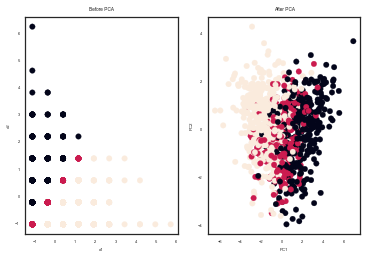

In [128]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(X[:,0], X[:,1], c=y.values)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(X_new[:,0], X_new[:,1], c=y.values)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()

In [129]:
print(pca.explained_variance_ratio_)

[0.26298566 0.11266282 0.09691789 0.09008577 0.07210515 0.06494418
 0.06288442 0.05671788]


In [76]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [81]:
# Apply PCA function on the training set using the 6 components

pca = PCA(n_components=1) 

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Fitting Logistic Regression model to the training set 
#classifier = LogisticRegression()
#classifier.fit(X_train, X_test)

#7 Predicting the test set result using
# predict function under LogisticRegression
#y_pred = classifier.predict(X_test)


In [48]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


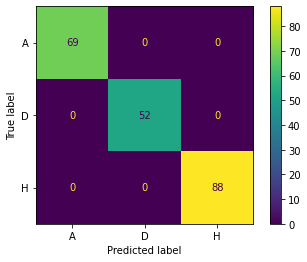

In [49]:
from sklearn import metrics
metrics.plot_confusion_matrix(logreg, X_test, y_test)
CM_logreg = metrics.confusion_matrix(y_test, y_pred_logreg)

Fitting estimator with 14 features.


RFE(estimator=LogisticRegression(), n_features_to_select=6, step=10, verbose=5)

6 selected features


In [35]:
rfe_feature

['FTHG', 'FTAG', 'HST', 'AST', 'AC', 'AR']

In [36]:
logreg_accuracy

NameError: name 'logreg_accuracy' is not defined

In [53]:
# Chart settings to use 
# Setting chart setting variables to be used throughout all charts
font = 'arial'
font_weight = 'bold'
ax_fontsize = '14'
background_colour = "#94D2BD"
colour_palette = ["#08acec","#005F73","#0A9396","#E9D8A6","#EE9B00"]

In [64]:
n = len(df_continuous)

# number of rows, based on cols
# Defines the layout of the plot so in this case dynamically setting to 5 rows and fixed 2 columns
rows = (int((n+1)/2))

# Instantiating plot and background colour
fig = plt.figure(figsize = (20, 20))
fig.patch.set_facecolor(background_colour)

for i, column in enumerate(df):
     ax = fig.add_subplot(rows , 2, i + 1)
     sns.kdeplot(ax = ax, data = df, x = column, hue = "FTR", palette = colour_palette)
     ax.set_title(column, fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
     ax.set_xlabel("")
     ax.set_ylabel("")
     ax.grid(color = "#000000", linestyle = ":", axis = 'y', zorder = 0, dashes = (1,5))
     ax.set_facecolor(background_colour)
    #

TypeError: cannot astype a datetimelike from [datetime64[ns]] to [float64]

In [15]:
X_test.head(1)

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
5465,2.0,1.0,1.0,1.0,12.0,8.0,7.0,5.0,9.0,9.0,4.0,3.0,0.0,1.0,0.0,0.0


In [16]:
logreg.predict(X_test.head(1))

array(['H'], dtype=object)

In [ ]:
player_stats_df.describe()

In [37]:
X

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
5321,4.0,1.0,4.0,0.0,15.0,12.0,7.0,5.0,9.0,9.0,11.0,2.0,0.0,2.0,0.0,0.0
5322,0.0,5.0,0.0,1.0,5.0,14.0,3.0,9.0,6.0,13.0,1.0,1.0,2.0,2.0,0.0,0.0
5323,1.0,1.0,0.0,0.0,13.0,8.0,3.0,3.0,10.0,19.0,3.0,4.0,2.0,1.0,0.0,0.0
5324,3.0,0.0,0.0,0.0,10.0,11.0,4.0,3.0,6.0,12.0,2.0,7.0,0.0,0.0,0.0,0.0
5325,0.0,0.0,0.0,0.0,6.0,10.0,2.0,3.0,16.0,14.0,6.0,2.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,1.0,0.0,1.0,0.0,6.0,10.0,3.0,4.0,12.0,22.0,3.0,6.0,2.0,4.0,0.0,0.0
6457,4.0,1.0,0.0,0.0,12.0,7.0,6.0,2.0,10.0,5.0,3.0,3.0,0.0,1.0,0.0,0.0
6458,3.0,1.0,1.0,1.0,29.0,7.0,8.0,5.0,6.0,3.0,5.0,3.0,1.0,0.0,0.0,0.0
6459,3.0,2.0,0.0,1.0,24.0,4.0,5.0,2.0,5.0,11.0,13.0,1.0,0.0,1.0,0.0,0.0


In [38]:
from sklearn.model_selection import KFold

model = LogisticRegression()
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X):
    X_train1, X_test1 = X[train_index], X[test_index]
    y_train1, y_test1 = y[train_index], y[test_index]

    # Fit the model on the training data
    model.fit(X_train1, y_train1)

    # Evaluate the model on the test data
    accuracy = model.score(X_test1, y_test1)
    print(accuracy)

KeyError: "None of [Int64Index([ 209,  210,  211,  212,  213,  214,  215,  216,  217,  218,\n            ...\n            1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040],\n           dtype='int64', length=832)] are in the [columns]"

In [ ]:
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
tables = (cur.fetchall())

# References

<span id="fn1"> </span>